In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
# pd.set_option('display.float_format', lambda x: '%.4f' % x)

pdkwargs = {'index_col': 'id'}
with open('dtype.json', 'r') as f:
    pdkwargs['dtype'] = json.loads(f.read())

df = pd.read_csv('data.csv', **pdkwargs)
df = df[~df['post_id'].isna()]
dup = df[df['post_id'].duplicated(keep=False)]
exclude = set(dup.index)
dup = dup[~dup['open_date'].isna()]
dup = dup.sort_values('post_id')
dup = dup.drop_duplicates(subset='post_id', keep='last')
exclude -= set(dup.index)
df = df[~df.index.isin(exclude)]
df['post_id'] = df['post_id'].astype('int32')
df = df.set_index('post_id')
df['place_type'] = pd.factorize(df['place_type'])[0]
df = df.drop(columns=['office_hours', 'metro_min_distance']) # df.isna().sum(axis=0) / len(num)
df = df.drop(columns=['shop_centre', 'dns']) # df[['shop_centre', 'dns']].describe()
df = df.dropna()
num = df.select_dtypes(exclude='object')
# obj = df.select_dtypes(include='object')

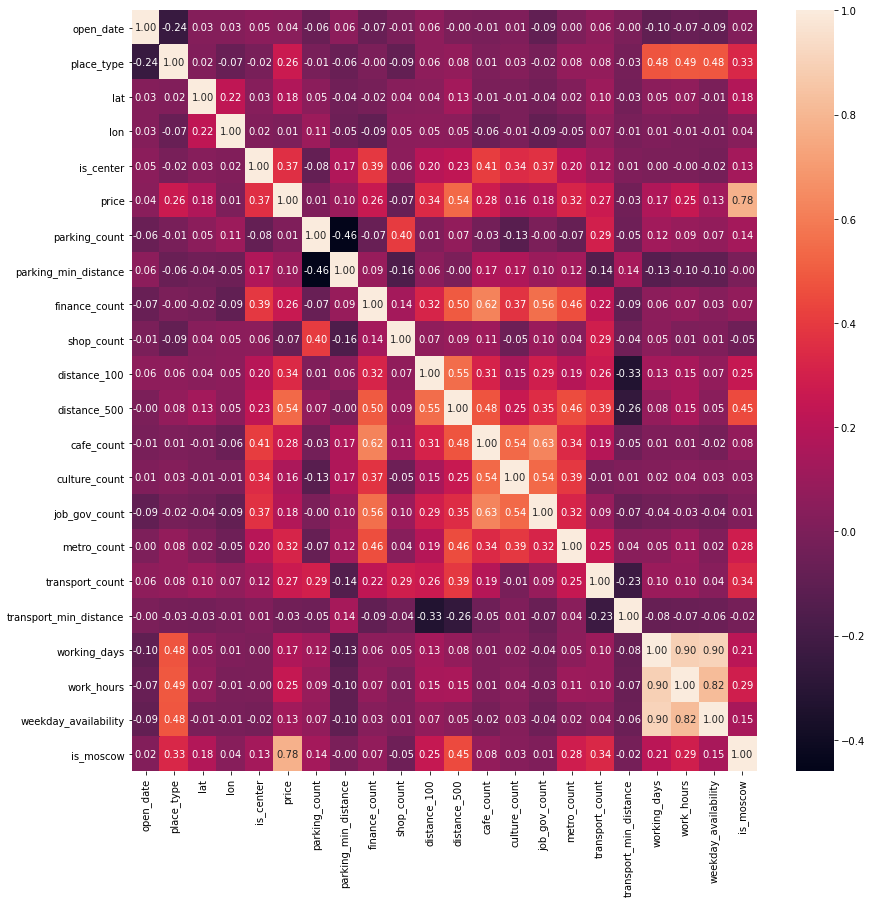

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 14))
sns.heatmap(num.corr(), annot=True, fmt='.2f')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
rs = 42

pipe = Pipeline([
    # ('scaler', StandardScaler()),
    ('pca', KernelPCA(n_components=3, kernel='cosine', random_state=rs)), # linear, cosine
    ('kmeans', KMeans(n_clusters=5, random_state=rs)),
])
pipe.fit(num)

pts = num.values.copy()
# pts = pipe['scaler'].transform(pts)
pts = pipe['pca'].transform(pts)
clf = pipe['kmeans'].predict(pts)
clr = {0: 'green', 1: 'blue', 2: 'orange', 3: 'pink', 4: 'red', 5: 'black'}

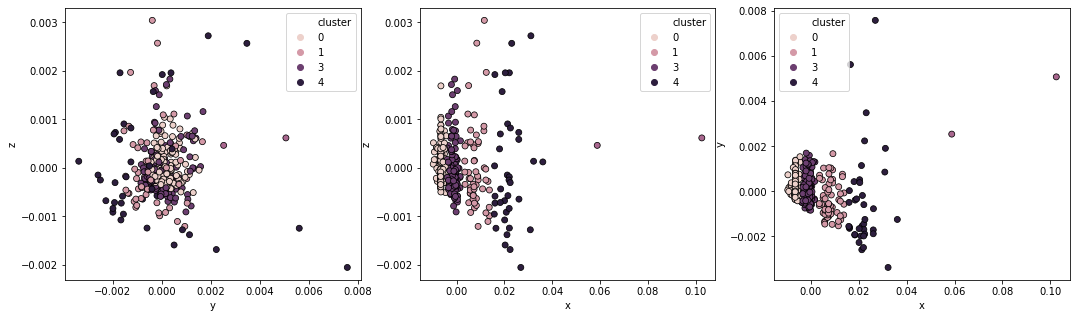

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
cols = ['x', 'y', 'z']
data = pipe['pca'].transform(num)
data = pd.DataFrame(data, columns=cols, index=df.index)
data['cluster'] = clf
n = range(pipe['pca'].n_components)
color = [clr[c] for c in clf]
for i in n:
    d = [j for j in n if j != i]
    sns.scatterplot(x=cols[d[0]], y=cols[d[1]], data=data, hue='cluster', ax=ax[i], edgecolor='black')
    # sns.scatterplot(data=data[:, d], ax=ax[i])

plt.show()

In [6]:
for c, centroid in enumerate(pipe['kmeans'].cluster_centers_):
    pts = data[data['cluster'] == c][cols].values
    dist = np.sqrt(np.square(pts - centroid).sum(axis=1, keepdims=True))
    data.loc[data['cluster'] == c, 'distance'] = dist

# pd.concat({k: data[data['cluster'] == k].describe() for k in np.unique(clf)})
concat = pd.concat((df, data), axis=1)
pd.concat({k: concat[concat['cluster'] == k].describe() for k in np.unique(clf)}).round(4)
#.reset_index().set_index(['cluster', 'post_id']).describe()

open_date  place_type       lat       lon  is_center        price  \
0 count   191.0000    191.0000  191.0000  191.0000   191.0000     191.0000   
  mean   2016.7015      0.7906   55.7400   37.5411     0.1152  226241.0938   
  std       0.6240      0.4207    0.3309    0.9888     0.3201   24680.6523   
  min    2015.0000      0.0000   52.6172   27.5474     0.0000  181534.0000   
  25%    2016.0000      1.0000   55.6865   37.5196     0.0000  227892.0000   
  50%    2017.0000      1.0000   55.7577   37.6000     0.0000  227892.0000   
  75%    2017.0000      1.0000   55.8083   37.6940     0.0000  227892.0000   
  max    2018.0000      2.0000   57.4486   39.5566     1.0000  352119.0000   
1 count    59.0000     59.0000   59.0000   59.0000    59.0000      59.0000   
  mean   2016.7627      0.4576   55.7143   37.4294     0.0000   87121.5078   
  std       0.6782      0.5025    0.3553    1.5305     0.0000   10242.4385   
  min    2016.0000      0.0000   53.8487   27.0655     0.0000   69178.0000   
  25%    2016.0000      0.0000   55.5679   37.4858     0.0000   82897.0000   
  50%    2017.0000      0.0000   55.7322   37.7377     0.0000   88558.0000   
  75%    2017.0000      1.0000   55.9121   37.8979     0.0000   94707.0000   
  max    2018.0000      1.0000   56.3646   38.2283     0.0000  106750.0000   
2 count     2.0000      2.0000    2.0000    2.0000     2.0000       2.0000   
  mean   2016.5000      1.0000   55.5233   38.4206     0.0000   22248.0000   
  std       0.7071      0.0000    0.0733    1.5907     0.0000    7185.6191   
  min    2016.0000      1.0000   55.4715   37.2958     0.0000   17167.0000   
  25%    2016.2500      1.0000   55.4974   37.8582     0.0000   19707.5000   
  50%    2016.5000      1.0000   55.5233   38.4206     0.0000   22248.0000   
  75%    2016.7500      1.0000   55.5492   38.9830     0.0000   24788.5000   
  max    2017.0000      1.0000   55.5751   39.5454     0.0000   27329.0000   
3 count   141.0000    141.0000  141.0000  141.0000   141.0000     141.0000   
  mean   2016.6737      0.7872   55.7721   37.6015     0.0000  147356.0938   
  std       0.6035      0.4107    0.1015    0.1473     0.0000   14906.8086   
  min    2016.0000      0.0000   55.5468   37.3105     0.0000  119387.0000   
  25%    2016.0000      1.0000   55.6878   37.4843     0.0000  135354.0000   
  50%    2017.0000      1.0000   55.7877   37.5990     0.0000  147098.0000   
  75%    2017.0000      1.0000   55.8595   37.7402     0.0000  159970.0000   
  max    2019.0000      1.0000   55.9735   37.8802     0.0000  174102.0000   
4 count    37.0000     37.0000   37.0000   37.0000    37.0000      37.0000   
  mean   2016.5135      0.4054   55.3627   37.5001     0.0000   54898.5938   
  std       0.5067      0.4977    0.6429    2.4014     0.0000    6419.3726   
  min    2016.0000      0.0000   53.7277   24.1693     0.0000   39185.0000   
  25%    2016.0000      0.0000   54.9255   37.3921     0.0000   53155.0000   
  50%    2017.0000      0.0000   55.2449   38.0750     0.0000   54795.0000   
  75%    2017.0000      1.0000   55.7985   38.4814     0.0000   59661.0000   
  max    2017.0000      1.0000   56.7633   39.0392     0.0000   64447.0000   

         parking_count  parking_min_distance  finance_count  shop_count  ...  \
0 count       191.0000              191.0000       191.0000    191.0000  ...   
  mean         25.3979              110.9676         3.5131     13.1414  ...   
  std          17.8820               79.2828         3.7146      6.0529  ...   
  min           1.0000               18.8793         0.0000      0.0000  ...   
  25%          13.0000               50.3020         1.0000      9.0000  ...   
  50%          21.0000               91.3653         2.0000     13.0000  ...   
  75%          33.0000              140.8533         5.0000     17.0000  ...   
  max          96.0000              480.6306        23.0000     31.0000  ...   
1 count        59.0000               59.0000        59.0000     59.0000  ...   
  mean    